## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Read Data

In [2]:
import os
import shutil 

current_parent = r"C:\Users\Mohamed Abdalkader\AnacondaProjects\AI_Projects\Deep learning Projects\Cancer\Brain Tumor\Data_"
new_parent = r"C:\Users\Mohamed Abdalkader\AnacondaProjects\AI_Projects\Deep learning Projects\Cancer\Brain Tumor\Data"

In [3]:
train_dirs = { sub_folder:[os.path.join(current_parent, "Training", sub_folder, i) for i in os.listdir(os.path.join(current_parent, "Training", sub_folder))] for sub_folder in os.listdir(os.path.join(current_parent, "Training"))}
test_dirs  = { sub_folder:[os.path.join(current_parent, "Testing", sub_folder, i) for i in os.listdir(os.path.join(current_parent, "Testing", sub_folder))] for sub_folder in os.listdir(os.path.join(current_parent, "Testing"))}

In [4]:
for key, value in train_dirs.items():
    print(f"{len(value)} in {key}")

1321 in glioma
1339 in meningioma
1595 in notumor
1457 in pituitary


In [5]:
for key, value in test_dirs.items():
    print(f"{len(value)} in {key}")

300 in glioma
306 in meningioma
405 in notumor
300 in pituitary


In [6]:
for key, value in test_dirs.items():
    train_dirs[key].extend(test_dirs[key])

In [7]:
for key, value in train_dirs.items():
    print(f"{len(value)} in {key}")

1621 in glioma
1645 in meningioma
2000 in notumor
1757 in pituitary


In [8]:
import random

for class_ in train_dirs.values():
    random.shuffle(class_)

In [9]:
sub_folders = ["Train", "Valid", "Test"]
for sub_folder in sub_folders:
    for class_ in train_dirs.keys():
        os.makedirs(os.path.join(new_parent, sub_folder, class_))
        
for key, value in train_dirs.items():
    # train 70, validation 15, test 15 
    for index, path in enumerate(value):
        if index < 0.7 * len(value):
            shutil.copy(path, os.path.join(new_parent, sub_folders[0], key))
        elif index < 0.85 * len(value):
            shutil.copy(path, os.path.join(new_parent, sub_folders[1], key))
        else:
            shutil.copy(path, os.path.join(new_parent, sub_folders[2], key))

In [11]:
image_shape = (512, 512)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_image_data_generator(parent_folder, image_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        # validation_split=validation_split  # Define validation split
    )

    generator = datagen.flow_from_directory(
        parent_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  # Use 'binary' for binary classification
        # subset=subset  # Choose "training" or "validation"
    )
    return generator

train_generator      = create_image_data_generator(r"Data/Train", image_shape, 32)
validation_generator = create_image_data_generator(r"Data/Valid", image_shape, 32)
test_generator       = create_image_data_generator(r"Data/Test", image_shape, 32)

Found 4917 images belonging to 4 classes.
Found 1054 images belonging to 4 classes.
Found 1052 images belonging to 4 classes.


In [12]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model3.keras', monitor='val_loss', save_best_only=True, mode='min')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
# Train the model
epochs = 100
batch_size = 32

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stop, checkpoint] # 
)

# Fine-tuning: Unfreeze the top layers of the model
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.7254 - loss: 0.6818 - val_accuracy: 0.2891 - val_loss: 3.0410 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.8948 - loss: 0.2931 - val_accuracy: 0.2910 - val_loss: 2.1609 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.8904 - loss: 0.3343 - val_accuracy: 0.2676 - val_loss: 2.8295 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9084 - loss: 0.2855 - val_accuracy: 0.2734 - val_loss: 5.4011 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9483 - loss: 0.1515 - val_accuracy: 0.3027 - val_loss: 3.7204 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.9371 - loss: 0.2026 - val_accuracy: 0.2773 - val_loss: 3.7370 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.9378 - loss: 0.183

In [14]:
model.save("final_model3.keras")

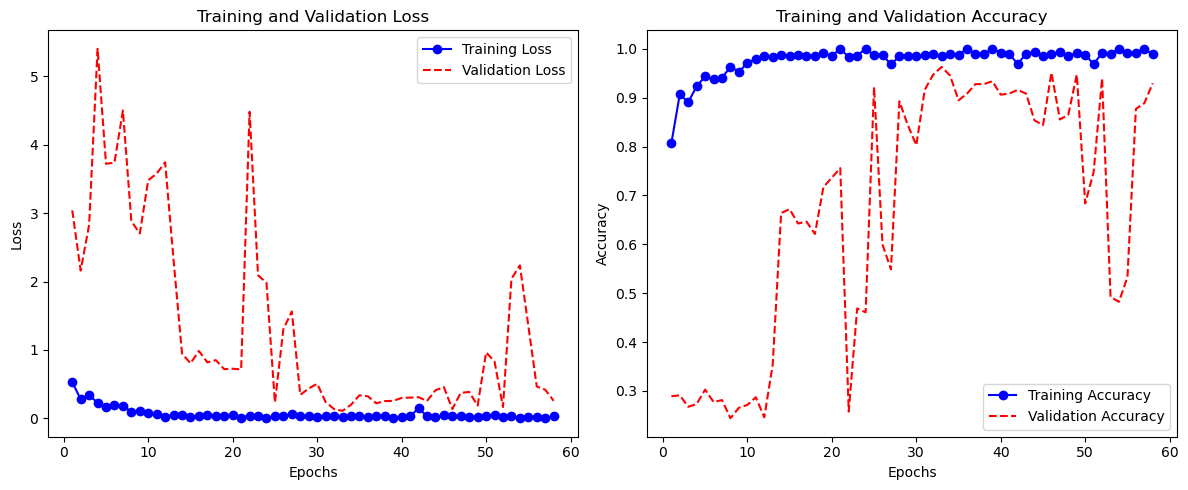

In [15]:
# Assuming `history` is the object returned from model.fit()
history_dict = history.history

# Extract loss and accuracy
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')  # Use .get() in case validation loss isn't available
accuracy = history_dict['accuracy']
val_accuracy = history_dict.get('val_accuracy')

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
model.evaluate(train_generator)
model.evaluate(validation_generator)
model.evaluate(test_generator)

154/154 ━━━━━━━━━━━━━━━━━━━━ 117s 721ms/step - accuracy: 0.9643 - loss: 0.0889
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 716ms/step - accuracy: 0.9587 - loss: 0.1250
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 982ms/step - accuracy: 0.9557 - loss: 0.1288


[0.12152618914842606, 0.9572243094444275]

In [65]:
import os
import numpy as np
import cv2

x_pathes = []
y = []

# Define a fixed image size (adjust as needed)
IMG_SIZE = (224, 224)  # Example: resizing to 224x224

# Base directory
test_dir = os.path.join(current_parent, "Test")

# Iterate over class folders
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    image_files = os.listdir(class_path)
    
    # Get full paths and append class labels
    paths = [os.path.join(class_path, img) for img in image_files]
    x_pathes.extend(paths)
    y.extend([class_folder] * len(paths))

# Load images into a NumPy array (Resizing to IMG_SIZE and ensuring 3 channels)
images = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), IMG_SIZE) for path in x_pathes], dtype=np.uint8)

y = np.array(y)
y = np.vectorize({'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}.get)(y)

print(images.shape)  # Should print (num_images, 224, 224, 3)

(1052, 224, 224, 3)


In [70]:
y_pred = model.predict(images)
y_pred = np.argmax(y_pred, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step
